In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

In [ ]:
from collections import Counter

def Classes_Count(generator, name):
    counter = Counter(generator.classes)
    class_indices = {v: k for k, v in generator.class_indices.items()}
    count_df = pd.DataFrame.from_dict(counter, orient='index', columns=[name])
    count_df.index = count_df.index.map(class_indices)
    return count_df

In [ ]:
# Data paths
train_dir = 'path to your train directory'
test_dir = 'path to your test directory'

In [ ]:
# Image parameters
img_shape = 224
batch_size = 64

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator for train and test data
train_preprocessor = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

test_preprocessor = ImageDataGenerator(
    rescale=1 / 255.

)

In [ ]:
# Load training data (90% of data)
train_data = train_preprocessor.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

# Load validation data (10% of data)
validation_data = train_preprocessor.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='validation'
)

test_data = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 10665 images belonging to 3 classes.
Found 1185 images belonging to 3 classes.
Found 2850 images belonging to 3 classes.


In [ ]:
# Count classes in train, validation, and test datasets
Train_Count = Classes_Count(train_data, 'Train').sort_values(by="Train", ascending=False)
Validation_Count = Classes_Count(validation_data, 'Validation').sort_values(by="Validation", ascending=False)
Test_Count = Classes_Count(test_data, 'Test').sort_values(by="Test", ascending=False)

# Concatenate the results
result = pd.concat([Train_Count, Validation_Count, Test_Count], axis=1)
result


,Train,Validation,Test
angry,3555,395,950
happy,3555,395,950
sad,3555,395,950


In [ ]:
ResNet50V2_base = ResNet50V2(input_shape=(img_shape, img_shape, 3),
                             include_top=False,
                             weights='imagenet'
                             )

# Freeze all layers except last 50
ResNet50V2_base.trainable = True
for layer in ResNet50V2_base.layers[:-50]:
    layer.trainable = False

# Custom model using ResNet50V2
def Create_Custom_ResNet50V2_Model():
    model = Sequential([
        ResNet50V2_base,
        Dropout(0.25),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    return model

ResNet50V2_Model = Create_Custom_ResNet50V2_Model()
ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
ResNet50V2_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 2048)        8192      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                     

In [ ]:
# Callbacks
checkpoint_path = "ResNet50V2_Model_Checkpoint.keras"
Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)
Early_Stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)
Reducing_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

callbacks = [Checkpoint,Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = validation_data.n // validation_data.batch_size

In [ ]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data,
                                          validation_data=validation_data,
                                          epochs=30,
                                          batch_size=batch_size,
                                           callbacks=callbacks,
                                          steps_per_epoch=steps_per_epoch,
                                           validation_steps=validation_steps)

Epoch 1/30
166/166 [==============================] - 2668s 15s/step - loss: 0.9963 - accuracy: 0.6226 - val_loss: 9.0890 - val_accuracy: 0.4931 - lr: 0.0010
Epoch 2/30
166/166 [==============================] - 204s 1s/step - loss: 0.7509 - accuracy: 0.6911 - val_loss: 1.1751 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 3/30
166/166 [==============================] - 199s 1s/step - loss: 0.6011 - accuracy: 0.7473 - val_loss: 0.5881 - val_accuracy: 0.7578 - lr: 0.0010
Epoch 4/30
166/166 [==============================] - 195s 1s/step - loss: 0.5360 - accuracy: 0.7799 - val_loss: 0.5756 - val_accuracy: 0.7465 - lr: 0.0010
Epoch 5/30
166/166 [==============================] - 197s 1s/step - loss: 0.4962 - accuracy: 0.7978 - val_loss: 0.5406 - val_accuracy: 0.8012 - lr: 0.0010
Epoch 6/30
166/166 [==============================] - 198s 1s/step - loss: 0.4651 - accuracy: 0.8097 - val_loss: 0.5090 - val_accuracy: 0.7882 - lr: 0.0010
Epoch 7/30
166/166 [==============================] - 195s 1s/

In [ ]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)
print("Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

45/45 [==============================] - 875s 20s/step - loss: 0.5387 - accuracy: 0.8004
Test Loss: 0.53869
Test Accuracy: 80.04%


In [ ]:
model_path = 'path to save the model'
ResNet50V2_Model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


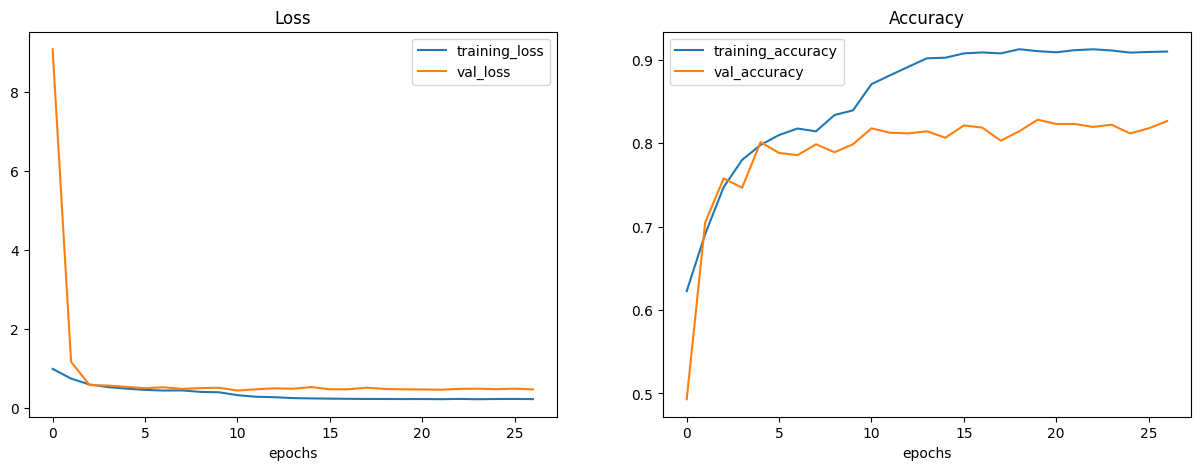

In [ ]:
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

plot_curves(ResNet50V2_history)